# Transfer Learning: Fine-Tuning




In [2]:
# Import helper functions we're going to use in this notebook
from Helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem

In [3]:
# get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")
walk_through_dir("10_food_classes_10_percent")

--2024-06-10 13:15:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4001:813::201b, 2a00:1450:4001:82f::201b, 2a00:1450:4001:827::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2a00:1450:4001:813::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.5’

10_food_classes_10_ 100%[===================>] 160,74M  35,5MB/s    in 5,2s    

2024-06-10 13:15:07 (30,8 MB/s) - ‘10_food_classes_10_percent.zip.5’ saved [168546183/168546183]

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'

In [4]:
#Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [5]:
import tensorflow as tf

IMG_SIZE= (224,224)
BATCH_SIZE=32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,image_size=IMG_SIZE,label_mode='categorical',batch_size=BATCH_SIZE)

test_data= tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,image_size=IMG_SIZE,label_mode='categorical',batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.


2024-06-10 13:15:08.359359: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-10 13:15:08.359387: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-10 13:15:08.359395: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-10 13:15:08.359434: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-10 13:15:08.359449: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2500 files belonging to 10 classes.


In [6]:
# check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[1.83357147e+02 1.65357147e+02 1.53357147e+02]
   [1.84260208e+02 1.66260208e+02 1.56260208e+02]
   [1.87785721e+02 1.69785721e+02 1.59785721e+02]
   ...
   [1.07137962e+02 8.72809067e+01 8.03472595e+01]
   [1.25091896e+02 1.14285805e+02 1.08994987e+02]
   [1.32586716e+02 1.25658257e+02 1.22301079e+02]]

  [[1.83357147e+02 1.65357147e+02 1.53357147e+02]
   [1.83928574e+02 1.65928574e+02 1.53928574e+02]
   [1.85326523e+02 1.67326523e+02 1.57326523e+02]
   ...
   [9.53113403e+01 7.48675079e+01 6.70563660e+01]
   [1.09132744e+02 9.62858276e+01 9.02909317e+01]
   [1.23785851e+02 1.15188950e+02 1.10995132e+02]]

  [[1.83000000e+02 1.65000000e+02 1.53000000e+02]
   [1.82801025e+02 1.64801025e+02 1.52801025e+02]
   [1.82214294e+02 1.64214294e+02 1.52551025e+02]
   ...
   [8.65919113e+01 6.33776512e+01 5.49491234e+01]
   [9.95715485e+01 8.22858582e+01 7.53981247e+01]
   [1.20490021e+02 1.06367569e+02 1.01561523e+02]]

  ...

  [[2.19714355e+02 2.04290848e+02 1.74000000e+02]
   [2

2024-06-10 13:15:08.761092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## model 0 : Building a transfer learning model using the keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [8]:
# 1.Create base model with tf.keras.application
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)


# Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3.Create input layer
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# 4.If using ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preproccessing.Rescaling(1./255)(inputs)

# 5.Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inouts through base model:{x.shape}")

# 6.Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAvaragePooling2: {x.shape}")
# 7.Create the output layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# 8.Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9.Compile the model
model_0.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

# 10.Fit the model
history_model_0 = model_0.fit(train_data_10_percent,epochs=5,validation_data=test_data, validation_steps=int(0.25 * len(test_data)),callbacks=[create_tensorboard_callback('transfer_learning','1-_percent_feature_extraction')])

Shape after passing inouts through base model:(None, 7, 7, 1280)
Shape after GlobalAvaragePooling2: (None, 1280)
Saving TensorBoard log files to: transfer_learning/1-_percent_feature_extraction/20240610-131510
Epoch 1/5


2024-06-10 13:15:13.364250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 409ms/step - accuracy: 0.1646 - loss: 2.2671 - val_accuracy: 0.6859 - val_loss: 1.4698
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.7291 - loss: 1.3204 - val_accuracy: 0.7812 - val_loss: 0.9542
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7722 - loss: 0.9704 - val_accuracy: 0.8405 - val_loss: 0.7473
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.8592 - loss: 0.7130 - val_accuracy: 0.8520 - val_loss: 0.6403
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.8558 - loss: 0.6597 - val_accuracy: 0.8676 - val_loss: 0.3812


2024-06-10 13:15:44.719980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-10 13:15:44.720002: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14210813958853744265
2024-06-10 13:15:44.720072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [9]:
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.8497 - loss: 0.5891


[0.5836732387542725, 0.8532000184059143]

In [10]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_layer
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [11]:
# How about we get summery of the base model?
base_model.summary()


Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          0 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [12]:
# How about summery from our model
model_0.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

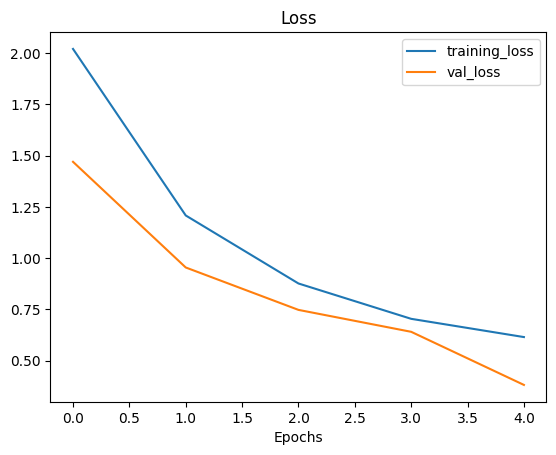

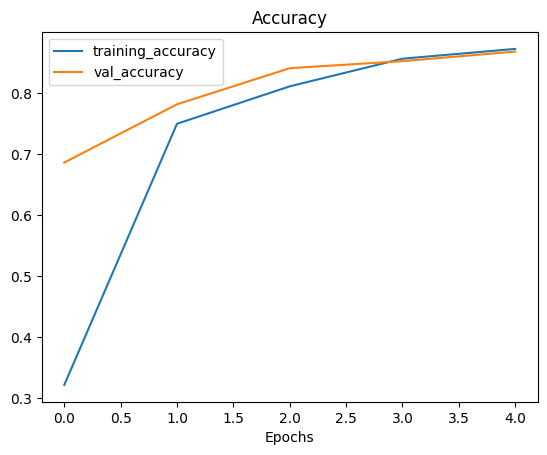

In [13]:
# chek out our model's training curves
plot_loss_curves(history_model_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape(none, 7, 7, 1280) .

But then when it passes through GlobalAvaregaePooling2d, it turns into (none, 1280) .

Let;s use a similar shaped tensor of (1, 4, 4, 3) and then passed it to GlobalAvaragePooling2D.

In [14]:
# Define the input shape
input_shape = (1,4,4,3)

# create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global average pooled random tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274686  -0.8426257   0.3194336 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.5397071   1.6994324 ]
   [ 0.28893656 -1.5066117  -0.26454768]]

  [[-0.5972242  -1.9171131  -0.6204413 ]
   [ 0.8504024  -0.4060477  -3.0258412 ]
   [ 0.9058465   0.29855984 -0.22561562]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772706]
   [ 0.24694408  0.20573746 -0.5256234 ]
   [ 0.32410023  0.02545409 -0.10638493]
   [-0.6369476   1.1603122   0.25073594]]

  [[-0.41728497  0.40125772 -1.4145442 ]
   [-0.5931858  -1.6617215   0.3356716 ]
   [ 0.1081563   0.23479682 -0.56668764]
   [-0.35819843  0.8869861   0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368647 -0.45840445 -0.28855982]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global average pooled random tensor: (1, 3)


In [15]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368647, -0.45840445, -0.28855982]], dtype=float32)>

## Running a series of transfer learning experiments

we've seen the incredible results transfer learning can get with only 10%  of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation

2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation

3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation

4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

**Note**: throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [17]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip


unzip_data("10_food_classes_1_percent.zip")
walk_through_dir("10_food_classes_1_percent")


train_dir = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"



--2024-06-10 13:18:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4001:812::201b, 2a00:1450:4001:813::201b, 2a00:1450:4001:82f::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2a00:1450:4001:812::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127,42M  18,2MB/s    in 12s     

2024-06-10 13:18:21 (10,5 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There

In [18]:
# Setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,label_mode="categorical",image_size=IMG_SIZE, batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,label_mode="categorical",image_size=IMG_SIZE, batch_size=BATCH_SIZE)


# Create data augmentation layer to pre-process our images (only during training)



Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.preprocessing`

The benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster)
* Image data augmentation only happens during training , so we can still export our whole model and use it elsewhere.


In [21]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.RandomZoom(0.2),
  #layers.Rescaling(1./255) # keep for models like ResNet50V2 but EfficientNet's having rescaling build-in
], name="data_augmentation")



## Visualize our data

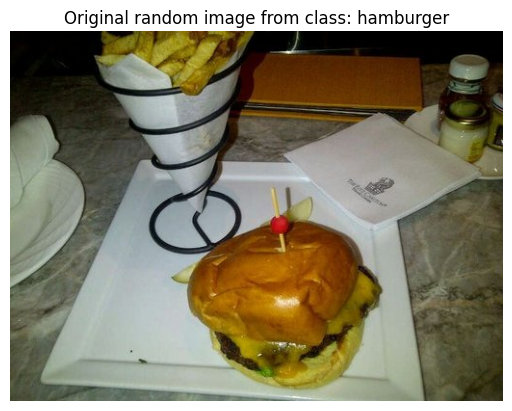

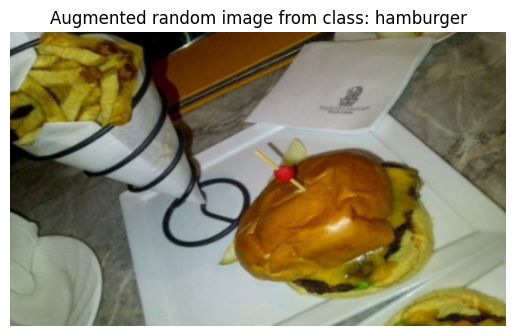

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice( train_data_10_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the image and plot it using matplotlib
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

## Model 1:Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x,training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

